In [23]:
 # 02_model_training.ipynb



In [24]:
# Cell 1: Imports & reproducibility
import os
import json
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
from datetime import datetime
SEED = 42
tf.random.set_seed(SEED)
np.random.seed(SEED)


In [25]:

USE_PREPROCESSED = True
PREP_DIR = "preprocessed"
OUT_DIR = "training_artifacts"
os.makedirs(OUT_DIR, exist_ok=True)
NUM_CLASSES = 10
BATCH_SIZE = 128
EPOCHS = 20
IMG_SHAPE = (32,32,3)


In [26]:
# Cell 3: Load data (prefer preprocessed .npz — else re-split CIFAR-10)
if USE_PREPROCESSED and os.path.exists(os.path.join(PREP_DIR, "cifar10_train.npz")):
    print("Loading preprocessed arrays...")
    train_np = np.load(os.path.join(PREP_DIR, "cifar10_train.npz"))
    val_np = np.load(os.path.join(PREP_DIR, "cifar10_val.npz"))
    test_np = np.load(os.path.join(PREP_DIR, "cifar10_test.npz"))
    X_train, y_train = train_np["X"], train_np["y"]
    X_val, y_val = val_np["X"], val_np["y"]
    X_test, y_test = test_np["X"], test_np["y"]
else:
    print("Loading CIFAR-10 and creating 70/15/15 splits...")
    (x_tr, y_tr), (x_te, y_te) = tf.keras.datasets.cifar10.load_data()
    X = np.concatenate([x_tr, x_te], axis=0)
    y = np.concatenate([y_tr, y_te], axis=0).reshape(-1)
    from sklearn.model_selection import train_test_split
    X_train, X_temp, y_train, y_temp = train_test_split(X, y, train_size=0.70, random_state=SEED, stratify=y)
    X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, train_size=0.5, random_state=SEED, stratify=y_temp)
    # normalize
    X_train = X_train.astype("float32") / 255.0
    X_val = X_val.astype("float32") / 255.0
    X_test = X_test.astype("float32") / 255.0

print("Shapes:", X_train.shape, y_train.shape, X_val.shape, y_val.shape, X_test.shape, y_test.shape)


Loading CIFAR-10 and creating 70/15/15 splits...
Shapes: (42000, 32, 32, 3) (42000,) (9000, 32, 32, 3) (9000,) (9000, 32, 32, 3) (9000,)


In [27]:
# ## Cell 4: One-hot encode labels and build tf.data datasets
# We use `tf.data` with augmentation applied to training dataset only.
# one-hot
y_train_cat = tf.keras.utils.to_categorical(y_train, NUM_CLASSES)
y_val_cat = tf.keras.utils.to_categorical(y_val, NUM_CLASSES)
y_test_cat = tf.keras.utils.to_categorical(y_test, NUM_CLASSES)

AUTOTUNE = tf.data.AUTOTUNE

# Data augmentation layers (we'll also show MixUp separately)
data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.08),
    layers.RandomZoom(0.08),
    layers.RandomContrast(0.08),
    layers.Lambda(lambda x: tf.image.random_brightness(x, max_delta=0.12))
], name="data_augmentation")

def make_ds(X, y, batch=BATCH_SIZE, shuffle=False, augment=False):
    ds = tf.data.Dataset.from_tensor_slices((X, y))
    if shuffle:
        ds = ds.shuffle(10000, seed=SEED)
    ds = ds.batch(batch).prefetch(AUTOTUNE)
    if augment:
        ds = ds.map(lambda images, labels: (data_augmentation(images, training=True), labels),
                    num_parallel_calls=AUTOTUNE)
    return ds

train_ds = make_ds(X_train, y_train_cat, shuffle=True, augment=True)
val_ds = make_ds(X_val, y_val_cat, shuffle=False, augment=False)
test_ds = make_ds(X_test, y_test_cat, shuffle=False, augment=False)


In [28]:
# ## Cell 5: Optional — MixUp augmentation function
# MixUp is applied on-batch. We'll create a wrapped dataset when enabled.
# MixUp implementation (alpha parameter)
def mixup(ds, alpha=0.2):
    def _mixup_batches(images, labels):
        # images: [B,H,W,C], labels: [B, num_classes]
        batch_size = tf.shape(images)[0]
        # sample lambda from Beta(alpha, alpha)
        lam = tfp.distributions.Beta(alpha, alpha).sample([batch_size], seed=SEED)
        lam_x = tf.reshape(lam, [batch_size, 1, 1, 1])
        lam_y = tf.reshape(lam, [batch_size, 1])
        # shuffle indices
        indices = tf.random.shuffle(tf.range(batch_size), seed=SEED)
        images2 = tf.gather(images, indices)
        labels2 = tf.gather(labels, indices)
        mixed_images = images * lam_x + images2 * (1 - lam_x)
        mixed_labels = labels * lam_y + labels2 * (1 - lam_y)
        return mixed_images, mixed_labels
    # map on dataset
    return ds.map(_mixup_batches, num_parallel_calls=AUTOTUNE)

# NOTE: to use MixUp we need tensorflow-probability; we'll import lazily if requested
USE_MIXUP = False
if USE_MIXUP:
    import tensorflow_probability as tfp
    train_ds = mixup(train_ds, alpha=0.2)


In [29]:
# ## Cell 6: Residual block helper (ResNet-style)
# We'll add a simple residual block for the network (Bonus credit).
def residual_block(x, filters, kernel_size=3, stride=1):
    shortcut = x
    x = layers.Conv2D(filters, kernel_size, strides=stride, padding='same', use_bias=False)(x)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)
    x = layers.Conv2D(filters, kernel_size, strides=1, padding='same', use_bias=False)(x)
    x = layers.BatchNormalization()(x)
    # adjust shortcut if number of filters or stride differs
    if shortcut.shape[-1] != filters or stride != 1:
        shortcut = layers.Conv2D(filters, 1, strides=stride, padding='same', use_bias=False)(shortcut)
        shortcut = layers.BatchNormalization()(shortcut)
    x = layers.Add()([x, shortcut])
    x = layers.ReLU()(x)
    return x


In [30]:
# ## Cell 7: Build the CNN model
# Requirements satisfied:
# - ≥3 convolutional layers (we include many),
# - BatchNorm, Dropout, Pooling,
# - GlobalAveragePooling before dense,
# - Softmax final layer with 10 outputs.
# We include a couple of residual blocks.
def build_model(input_shape=IMG_SHAPE, num_classes=NUM_CLASSES, dropout_rate=0.3):
    inputs = layers.Input(shape=input_shape)
    x = layers.Rescaling(1./1.0)(inputs)  # assume inputs already in [0,1]; keep for compatibility

    # Stem
    x = layers.Conv2D(64, 3, padding='same', use_bias=False)(x)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)

    # Conv block 1
    x = layers.Conv2D(64, 3, padding='same', use_bias=False)(x)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)
    x = layers.MaxPooling2D(2)(x)
    x = layers.Dropout(dropout_rate)(x)

    # Residual block(s)
    x = residual_block(x, 128, stride=1)
    x = layers.MaxPooling2D(2)(x)
    x = layers.Dropout(dropout_rate)(x)

    # Conv block 2
    x = layers.Conv2D(256, 3, padding='same', use_bias=False)(x)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)
    x = layers.Conv2D(256, 3, padding='same', use_bias=False)(x)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)
    x = layers.MaxPooling2D(2)(x)
    x = layers.Dropout(dropout_rate)(x)

    # Global pooling + Dense head
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dense(256, use_bias=False)(x)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)
    x = layers.Dropout(0.4)(x)
    outputs = layers.Dense(num_classes, activation='softmax')(x)

    model = keras.Model(inputs, outputs, name="cifar_custom_resnet_like")
    return model

model = build_model()
model.summary()


Model: "cifar_custom_resnet_like"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_5       │ (None, 32, 32, 3) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling_2         │ (None, 32, 32, 3) │          0 │ input_layer_5[0]… │
│ (Rescaling)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_14 (Conv2D)  │ (None, 32, 32,    │      1,728 │ rescaling_2[0][0] │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 32, 32,    │        256 │ conv2d_14[0][0]   │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_14 (ReLU)     │ (None, 32, 32,    │          0 │ batch_normalizat… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_15 (Conv2D)  │ (None, 32, 32,    │     36,864 │ re_lu_14[0][0]    │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 32, 32,    │        256 │ conv2d_15[0][0]   │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_15 (ReLU)     │ (None, 32, 32,    │          0 │ batch_normalizat… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_6     │ (None, 16, 16,    │          0 │ re_lu_15[0][0]    │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_8 (Dropout) │ (None, 16, 16,    │          0 │ max_pooling2d_6[… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_16 (Conv2D)  │ (None, 16, 16,    │     73,728 │ dropout_8[0][0]   │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 16, 16,    │        512 │ conv2d_16[0][0]   │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_16 (ReLU)     │ (None, 16, 16,    │          0 │ batch_normalizat… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_17 (Conv2D)  │ (None, 16, 16,    │    147,456 │ re_lu_16[0][0]    │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_18 (Conv2D)  │ (None, 16, 16,    │      8,192 │ dropout_8[0][0]   │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 16, 16,    │        512 │ conv2d_17[0][0]   │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 16, 16,    │        512 │ conv2d_18[0][0] 

 Total params: 1,225,930 (4.68 MB)

 Trainable params: 1,223,370 (4.67 MB)

 Non-trainable params: 2,560 (10.00 KB)

In [31]:
# ## Cell 8: Compile model with optimizer, loss, metrics
# We use Adam (good default) + categorical crossentropy. We'll add learning rate scheduler & callbacks.
# Custom learning rate schedule (cosine annealing-like via ReduceLROnPlateau + scheduler)
initial_lr = 1e-3
optimizer = keras.optimizers.Adam(learning_rate=initial_lr)
model.compile(
    optimizer=optimizer,
    loss="categorical_crossentropy",
    metrics=["accuracy"]
)


In [32]:
# ## Cell 9: Callbacks
# - EarlyStopping to avoid overfitting
# - ModelCheckpoint to save best model (`best_model.h5`)
# - ReduceLROnPlateau for LR scheduling
# - CSVLogger for simple logs
timestamp = datetime.now().strftime("%Y%m%d-%H%M%S")
best_model_path = os.path.join(OUT_DIR, "best_model.h5")
history_json = os.path.join(OUT_DIR, "training_history.json")
train_plot = os.path.join(OUT_DIR, "train_val_curves.png")
cm_plot = os.path.join(OUT_DIR, "confusion_matrix.png")

callbacks = [
    keras.callbacks.EarlyStopping(monitor="val_loss", patience=8, restore_best_weights=False),
    keras.callbacks.ModelCheckpoint(best_model_path, monitor="val_accuracy", save_best_only=True, save_weights_only=False),
    keras.callbacks.ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=3, min_lr=1e-6),
    keras.callbacks.CSVLogger(os.path.join(OUT_DIR, f"training_log_{timestamp}.csv"))
]


In [33]:
# ## Cell 10: Train the model
# We train for up to `EPOCHS`. If GPU is available on Colab this will be reasonably fast.
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=EPOCHS,
    callbacks=callbacks
)
# Save history
with open(history_json, "w") as f:
    json.dump(history.history, f)
print("Saved training history to", history_json)


Epoch 1/20
329/329 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step - accuracy: 0.3249 - loss: 1.9078

329/329 ━━━━━━━━━━━━━━━━━━━━ 31s 62ms/step - accuracy: 0.3251 - loss: 1.9071 - val_accuracy: 0.1120 - val_loss: 4.0752 - learning_rate: 0.0010
Epoch 2/20
328/329 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - accuracy: 0.5193 - loss: 1.3323

329/329 ━━━━━━━━━━━━━━━━━━━━ 27s 39ms/step - accuracy: 0.5194 - loss: 1.3320 - val_accuracy: 0.5729 - val_loss: 1.2653 - learning_rate: 0.0010
Epoch 3/20
329/329 ━━━━━━━━━━━━━━━━━━━━ 13s 38ms/step - accuracy: 0.5918 - loss: 1.1431 - val_accuracy: 0.5383 - val_loss: 1.3712 - learning_rate: 0.0010
Epoch 4/20
329/329 ━━━━━━━━━━━━━━━━━━━━ 13s 38ms/step - accuracy: 0.6243 - loss: 1.0538 - val_accuracy: 0.5642 - val_loss: 1.3507 - learning_rate: 0.0010
Epoch 5/20
328/329 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - accuracy: 0.6607 - loss: 0.9633

329/329 ━━━━━━━━━━━━━━━━━━━━ 20s 38ms/step - accuracy: 0.6608 - loss: 0.9631 - val_accuracy: 0.5892 - val_loss: 1.3160 - learning_rate: 0.0010
Epoch 6/20
327/329 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - accuracy: 0.7010 - loss: 0.8507

329/329 ━━━━━━━━━━━━━━━━━━━━ 13s 38ms/step - accuracy: 0.7011 - loss: 0.8505 - val_accuracy: 0.6813 - val_loss: 0.9100 - learning_rate: 5.0000e-04
Epoch 7/20
327/329 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - accuracy: 0.7259 - loss: 0.7863

329/329 ━━━━━━━━━━━━━━━━━━━━ 13s 39ms/step - accuracy: 0.7259 - loss: 0.7863 - val_accuracy: 0.7167 - val_loss: 0.8210 - learning_rate: 5.0000e-04
Epoch 8/20
329/329 ━━━━━━━━━━━━━━━━━━━━ 14s 42ms/step - accuracy: 0.7328 - loss: 0.7625 - val_accuracy: 0.7097 - val_loss: 0.8692 - learning_rate: 5.0000e-04
Epoch 9/20
328/329 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - accuracy: 0.7439 - loss: 0.7315

329/329 ━━━━━━━━━━━━━━━━━━━━ 14s 43ms/step - accuracy: 0.7439 - loss: 0.7315 - val_accuracy: 0.7170 - val_loss: 0.8666 - learning_rate: 5.0000e-04
Epoch 10/20
328/329 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - accuracy: 0.7542 - loss: 0.6999

329/329 ━━━━━━━━━━━━━━━━━━━━ 13s 38ms/step - accuracy: 0.7543 - loss: 0.6999 - val_accuracy: 0.7596 - val_loss: 0.7058 - learning_rate: 5.0000e-04
Epoch 11/20
329/329 ━━━━━━━━━━━━━━━━━━━━ 20s 38ms/step - accuracy: 0.7620 - loss: 0.6863 - val_accuracy: 0.7511 - val_loss: 0.7337 - learning_rate: 5.0000e-04
Epoch 12/20
329/329 ━━━━━━━━━━━━━━━━━━━━ 21s 40ms/step - accuracy: 0.7649 - loss: 0.6709 - val_accuracy: 0.6896 - val_loss: 0.9797 - learning_rate: 5.0000e-04
Epoch 13/20
329/329 ━━━━━━━━━━━━━━━━━━━━ 13s 38ms/step - accuracy: 0.7693 - loss: 0.6553 - val_accuracy: 0.7470 - val_loss: 0.7598 - learning_rate: 5.0000e-04
Epoch 14/20
327/329 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - accuracy: 0.7922 - loss: 0.6044

329/329 ━━━━━━━━━━━━━━━━━━━━ 21s 41ms/step - accuracy: 0.7922 - loss: 0.6042 - val_accuracy: 0.8099 - val_loss: 0.5438 - learning_rate: 2.5000e-04
Epoch 15/20
328/329 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - accuracy: 0.8041 - loss: 0.5638

329/329 ━━━━━━━━━━━━━━━━━━━━ 13s 38ms/step - accuracy: 0.8041 - loss: 0.5638 - val_accuracy: 0.8161 - val_loss: 0.5346 - learning_rate: 2.5000e-04
Epoch 16/20
329/329 ━━━━━━━━━━━━━━━━━━━━ 13s 38ms/step - accuracy: 0.8035 - loss: 0.5639 - val_accuracy: 0.7907 - val_loss: 0.6217 - learning_rate: 2.5000e-04
Epoch 17/20
329/329 ━━━━━━━━━━━━━━━━━━━━ 20s 38ms/step - accuracy: 0.8063 - loss: 0.5476 - val_accuracy: 0.8026 - val_loss: 0.5840 - learning_rate: 2.5000e-04
Epoch 18/20
327/329 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - accuracy: 0.8153 - loss: 0.5360

329/329 ━━━━━━━━━━━━━━━━━━━━ 13s 39ms/step - accuracy: 0.8153 - loss: 0.5360 - val_accuracy: 0.8234 - val_loss: 0.5133 - learning_rate: 2.5000e-04
Epoch 19/20
329/329 ━━━━━━━━━━━━━━━━━━━━ 13s 38ms/step - accuracy: 0.8155 - loss: 0.5333 - val_accuracy: 0.8220 - val_loss: 0.5325 - learning_rate: 2.5000e-04
Epoch 20/20
329/329 ━━━━━━━━━━━━━━━━━━━━ 21s 38ms/step - accuracy: 0.8199 - loss: 0.5165 - val_accuracy: 0.8012 - val_loss: 0.5901 - learning_rate: 2.5000e-04
Saved training history to training_artifacts/training_history.json


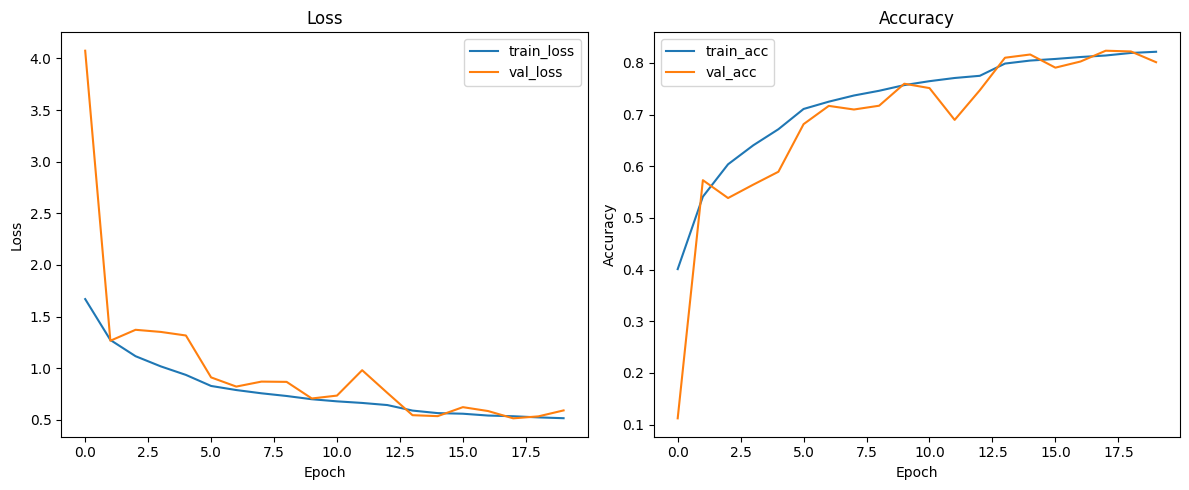

Saved training curves to training_artifacts/train_val_curves.png


In [34]:
## Cell 11: Plot training & validation curves
# Load history (already saved)
h = history.history
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(h['loss'], label='train_loss')
plt.plot(h['val_loss'], label='val_loss')
plt.xlabel('Epoch'); plt.ylabel('Loss'); plt.legend(); plt.title('Loss')

plt.subplot(1,2,2)
plt.plot(h['accuracy'], label='train_acc')
plt.plot(h['val_accuracy'], label='val_acc')
plt.xlabel('Epoch'); plt.ylabel('Accuracy'); plt.legend(); plt.title('Accuracy')

plt.tight_layout()
plt.savefig(train_plot)
plt.show()
print("Saved training curves to", train_plot)


71/71 ━━━━━━━━━━━━━━━━━━━━ 3s 19ms/step - accuracy: 0.8231 - loss: 0.5043
Test loss, Test accuracy: [0.5030272603034973, 0.8255555629730225]
71/71 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step
Classification Report:
               precision    recall  f1-score   support

           0     0.9124    0.7867    0.8449       900
           1     0.8899    0.9522    0.9200       900
           2     0.7426    0.7822    0.7619       900
           3     0.8409    0.5167    0.6401       900
           4     0.8128    0.8200    0.8164       900
           5     0.6681    0.8389    0.7438       900
           6     0.7316    0.9267    0.8176       900
           7     0.8989    0.8200    0.8576       900
           8     0.9402    0.9267    0.9334       900
           9     0.9119    0.8856    0.8985       900

    accuracy                         0.8256      9000
   macro avg     0.8349    0.8256    0.8234      9000
weighted avg     0.8349    0.8256    0.8234      9000



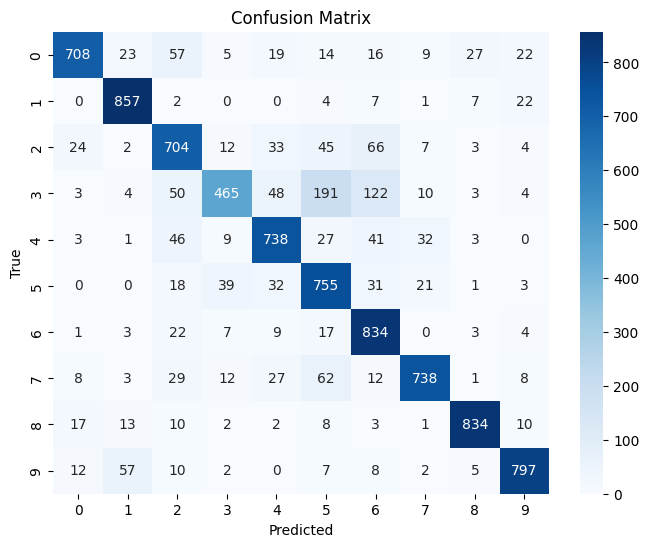

Saved confusion matrix to training_artifacts/confusion_matrix.png


In [35]:
# ## Cell 12: Evaluate on test set and create classification report + confusion matrix
# We load the best model saved by ModelCheckpoint (best_model.h5).
# Load best model
best_model = keras.models.load_model(best_model_path)
test_results = best_model.evaluate(test_ds, verbose=1)
print("Test loss, Test accuracy:", test_results)

# Predict on test set (gather all predictions)
y_pred_prob = best_model.predict(test_ds)
y_pred = np.argmax(y_pred_prob, axis=1)

# Get true labels from dataset in same order
y_true = np.concatenate([np.argmax(y, axis=1) for _, y in test_ds], axis=0)

# classification report
report = classification_report(y_true, y_pred, digits=4)
print("Classification Report:\n", report)
with open(os.path.join(OUT_DIR, "classification_report.txt"), "w") as f:
    f.write(report)

# confusion matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel("Predicted"); plt.ylabel("True"); plt.title("Confusion Matrix")
plt.savefig(cm_plot)
plt.show()
print("Saved confusion matrix to", cm_plot)
